# 环境说明

In [10]:
!python -V

Python 3.11.5


In [6]:
import sklearn
import pandas
import numpy
import matplotlib

In [3]:
sklearn.__version__

'1.5.2'

In [4]:
pandas.__version__

'2.1.1'

In [7]:
numpy.__version__

'1.26.4'

In [14]:
matplotlib.__version__

'3.8.0'

# 代码实现

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from statsmodels.nonparametric.smoothers_lowess import lowess

In [3]:
df = pd.read_csv("data/train.csv")

In [4]:
df.head()

,Age,Blood_Sugar,Blood_Pressure,Weight,Heart_Disease
0,58,99.975461,106.328124,62.448684,0
1,71,93.609515,134.190672,67.875853,0
2,48,119.131949,115.773278,49.263101,0
3,34,98.626509,117.651983,93.111787,0
4,62,114.056088,119.456831,71.043221,0


In [5]:
label_name = 'Heart_Disease'

In [52]:
X = df.drop(label_name, axis=1)
y = df[label_name]

In [53]:
# 添加常数列（截距项）到特征中
X_ = sm.add_constant(X)

# 拟合逻辑回归模型
model = sm.Logit(y, X_)
result = model.fit()

In [53]:
# 输出模型摘要
print(result.summary())

# 进行预测（概率值）
y_pred_prob = result.predict(X_)
# 将概率值转化为0/1预测类别，使用阈值0.5
y_pred_class = (y_pred_prob > 0.5).astype(int)
# 计算准确率
accuracy = accuracy_score(y, y_pred_class)
print(f"准确率: {accuracy:.4f}")

# 计算AUC（曲线下面积）
auc = roc_auc_score(y, y_pred_prob)
print(f"AUC: {auc:.4f}")

Optimization terminated successfully.
         Current function value: 0.022594
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:          Heart_Disease   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      995
Method:                           MLE   Df Model:                            4
Date:                Wed, 19 Feb 2025   Pseudo R-squ.:                  0.8405
Time:                        14:52:46   Log-Likelihood:                -22.594
converged:                       True   LL-Null:                       -141.63
Covariance Type:            nonrobust   LLR p-value:                 2.421e-50
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -109.6707     24.800     -4.422      0.000    -158.278     -61.064
Age             

D:\software\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


# Apparent计算

In [54]:
y_true, y_prob = y, y_pred_prob

## 预测概率采样

In [55]:
import numpy as np

# 假设 predicted 是一个已定义的列表或数组
n = len(y_prob)  # 获取 predicted 的长度
p = np.sort(y_prob)  # 对 predicted 进行排序
predy = np.linspace(p[4], p[n-5], num=50)  # 创建一个从 p[5] 到 p[n-4] 的等间隔序列，长度为 50

In [56]:
predy[:5]

array([6.48726475e-24, 2.04054528e-02, 4.08109056e-02, 6.12163585e-02,
       8.16218113e-02])

## lowess平滑

https://blog.csdn.net/zdx1996/article/details/120301814   
LOESS局部加权回归 - 是刘同学呀的文章 - 知乎
https://zhuanlan.zhihu.com/p/594727818

lowess（局部加权回归）是 R 语言中用于平滑数据的一个函数。它通过对数据点使用局部加权回归（Locally Weighted Scatterplot Smoothing, LOWESS）方法来创建平滑的曲线，从而使得原始数据的噪声得到平滑处理，并揭示出数据的趋势或模式。

In [57]:
(max(y_prob) - min(y_prob)) * 0.01

0.009999982225169384

In [307]:
smo = lowess(endog=y_true, exog=y_prob
                  ,frac=2/3 # frac 参数类似于 R 中的 f，控制窗口大小
                  ,it=0
                  ,delta=(max(y_prob) - min(y_prob)) * 0.01
                 )  

In [308]:
#  第一列是原始数据, 第二列是平滑后的
pd.DataFrame(smo).head()

,0,1
0,1.987025e-25,0.0
1,7.686511e-25,0.0
2,4.362426e-24,0.0
3,5.679777e-24,0.0
4,6.487265e-24,0.0


## 插值填补

当你调用 interp_function(predy) 时，interp_function 会基于已有的 smo[:, 0] 和 smo[:, 1] 进行插值，计算出 predy 中每个点对应的纵坐标值。换句话说，interp_function 会根据 predy 中的点查找在 smo 中的最接近的点，然后用插值方法（线性插值、立方插值等）计算 predy 的目标值。

In [60]:
from scipy.interpolate import interp1d
interp_function = interp1d(smo[:, 0], smo[:, 1], kind='linear', fill_value='extrapolate', assume_sorted=False)
# 进行插值
cal = interp_function(predy)

In [64]:
cal[:5]

array([0.        , 0.        , 0.03531016, 0.09656184, 0.18143783])

In [78]:
len(cal)

50

## Apparent作图

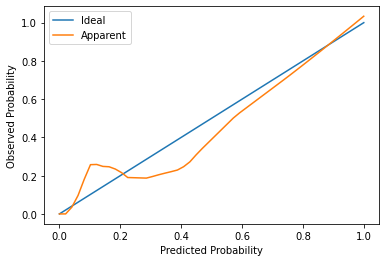

In [65]:
# "Ideal" 理想校准曲线 (y=x)
ideal_line = [0, 1]
plt.figure()
# 开始画图
# Ideal (理想曲线)
plt.plot(ideal_line, ideal_line, label='Ideal')
# Apparent (表观曲线)
plt.plot(predy, cal, label='Apparent')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Probability')
plt.legend()

# Corrected计算

## 单次循环

In [68]:
nrow = len(X)
nrow

1000

In [69]:
sample_train_id_list = np.random.choice(nrow, size=nrow, replace=True)

In [71]:
len(sample_train_id_list)

1000

In [74]:
# 因为有放回，所以有重复
len(set(sample_train_id_list))

639

In [84]:
sample_test_id_list = range(0, nrow)

In [325]:
def measure(true, prob, predy):
    smo = lowess(true, prob
                  ,frac=2/3 # frac 参数类似于 R 中的 f，控制窗口大小
                  ,it=0
                  ,delta=(max(prob) - min(prob)) * 0.01
                 ) 
    interp_function = interp1d(smo[:, 0], smo[:, 1], kind='linear', fill_value='extrapolate', assume_sorted=False)
    # 进行插值
    cal = interp_function(predy)
    return cal - predy

In [343]:
def new_measure(true, prob):
    n = len(prob)  # 获取 predicted 的长度
    p = np.sort(prob)  # 对 predicted 进行排序
    predy = np.linspace(p[4], p[n-5], num=50)  # 创建一个从 p[5] 到 p[n-4] 的等间隔序列，长度为 50
    smo = lowess(true, prob
                  ,frac=2/3 # frac 参数类似于 R 中的 f，控制窗口大小
                  ,it=0
                  ,delta=(max(prob) - min(prob)) * 0.01
                 ) 
    interp_function = interp1d(smo[:, 0], smo[:, 1], kind='linear', fill_value='extrapolate', assume_sorted=False)
    # 进行插值
    cal = interp_function(predy)
    return cal - predy

In [326]:
sample_train_stat = measure(y_true[sample_train_id_list]
                            ,y_prob[sample_train_id_list]
                            ,predy)

In [327]:
sample_test_stat = measure(y_true[sample_test_id_list]
                            ,y_prob[sample_test_id_list]
                            ,predy)

## 开始循环

In [328]:
B = 100

In [344]:
train_stat, test_stat, num = np.zeros(len(predy)), np.zeros(len(predy)), np.zeros(len(predy))

for i in range(B):
    sample_train_id_list = np.random.choice(nrow, size=nrow, replace=True)
    sample_test_id_list = range(0, nrow)
    sample_X = X.iloc[sample_train_id_list, :]
    sample_y = y.iloc[sample_train_id_list]
    # 添加常数列（截距项）到特征中
    sample_X_ = sm.add_constant(sample_X)
    # 拟合采样数据的逻辑回归模型
    sample_model = sm.Logit(sample_y, sample_X_)
    sample_result = model.fit()
    # 采样模型的结果去预测原本全部数据集x，然后再根据此次的采样结果取出预测值
    new_total_y_prob = sample_result.predict(X_)
    sample_y_prob = new_total_y_prob.iloc[sample_train_id_list]
    sample_y_true = sample_y
    sample_train_stat = new_measure(sample_y_true
                            ,sample_y_prob)
    # 同样用新拟合的模型结果来看一下全量结果（测试集）
    sample_test_stat = new_measure(y, new_total_y_prob)
    if any(np.isnan(sample_train_stat)) or any(np.isnan(sample_test_stat)):
        error = {'sample_X': sample_X, 'sample_y': sample_y, 'sample_model': sample_result}
    num += ~np.isnan(sample_train_stat + sample_test_stat)
    sample_train_stat = np.nan_to_num(sample_train_stat, nan=0)
    sample_test_stat = np.nan_to_num(sample_test_stat, nan=0)
    train_stat += sample_train_stat
    test_stat += sample_test_stat

D:\software\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.022594
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.022594
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.022594
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.022594
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.022594
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.022594
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.022594
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.022594
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.022594
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.

In [345]:
optimism = (train_stat - test_stat) / num

In [346]:
train_stat / num, test_stat / num

(array([-1.33490770e-23, -2.03404866e-02, -3.72655068e-03,  3.79216787e-02,
         9.99418281e-02,  1.48083639e-01,  1.38561809e-01,  1.07272659e-01,
         8.18011164e-02,  5.11809395e-02,  1.53619504e-02, -2.74820044e-02,
        -5.08266141e-02, -7.39160880e-02, -9.70055618e-02, -1.14425173e-01,
        -1.31077314e-01, -1.46473032e-01, -1.61210461e-01, -1.75616557e-01,
        -1.82062293e-01, -1.80938648e-01, -1.69305795e-01, -1.55105947e-01,
        -1.42419812e-01, -1.29749664e-01, -1.17079515e-01, -1.04409366e-01,
        -9.17392179e-02, -8.17363617e-02, -7.56314824e-02, -7.03066415e-02,
        -6.57867105e-02, -6.12821343e-02, -5.67775580e-02, -5.22729818e-02,
        -4.77684055e-02, -4.31143120e-02, -3.81026682e-02, -3.28473380e-02,
        -2.73709697e-02, -2.16425674e-02, -1.57122841e-02, -9.51076781e-03,
        -3.27964729e-03,  2.95928033e-03,  9.32098612e-03,  1.59085138e-02,
         2.26462484e-02,  2.94682491e-02]),
 array([-6.48726475e-24, -2.04054528e-02, -5

In [347]:
optimism

array([-6.86181222e-24,  6.49661905e-05,  1.77419243e-03,  2.57619321e-03,
        1.25806121e-04, -7.37765990e-03,  2.36966709e-03,  1.66033379e-03,
       -1.48005597e-03,  2.52499491e-04,  3.47388430e-03,  6.69250548e-03,
        4.76829109e-03,  3.09921259e-03,  1.43013409e-03, -4.00927474e-03,
       -9.42268468e-03, -1.27052205e-02, -1.48759589e-02, -1.73389113e-02,
       -2.08666377e-02, -2.45044910e-02, -2.88242032e-02, -2.78828930e-02,
       -2.66216336e-02, -2.53763602e-02, -2.41310868e-02, -2.28858133e-02,
       -2.16405399e-02, -1.80443828e-02, -1.58042444e-02, -1.43619411e-02,
       -1.37495241e-02, -1.31524620e-02, -1.25553998e-02, -1.19583377e-02,
       -1.13612755e-02, -1.09262189e-02, -1.05897795e-02, -1.01718110e-02,
       -9.69903997e-03, -9.15224684e-03, -8.57431499e-03, -8.02075447e-03,
       -7.43758972e-03, -6.84661786e-03, -6.27776327e-03, -5.63571399e-03,
       -4.92337634e-03, -4.19547572e-03])

In [348]:
corrected = cal - optimism

In [349]:
ex, ey, emodel = error['sample_X'], error['sample_y'], error['sample_model']

In [350]:
emodel.predict(sm.add_constant(ex))

557    1.884406e-09
413    4.036556e-11
975    1.573429e-18
351    7.742349e-09
539    5.195001e-15
           ...     
388    1.529035e-14
716    2.514173e-16
749    1.995456e-23
754    2.526203e-10
327    1.621275e-15
Length: 1000, dtype: float64

In [351]:
np.isnan(emodel.predict(sm.add_constant(ex))).sum()

0

In [352]:
num

array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100.])

In [353]:
corrected

array([ 6.86181222e-24, -6.49661905e-05,  3.35359701e-02,  9.39856508e-02,
        1.81312027e-01,  2.64866223e-01,  2.56255192e-01,  2.46790161e-01,
        2.48004851e-01,  2.34325016e-01,  2.12468710e-01,  1.83592966e-01,
        1.84502238e-01,  1.85156374e-01,  1.85810510e-01,  1.99675169e-01,
        2.14255300e-01,  2.25830107e-01,  2.35839608e-01,  2.46764869e-01,
        2.67780039e-01,  2.96584843e-01,  3.37262574e-01,  3.69985254e-01,
        4.00554323e-01,  4.31139377e-01,  4.61724432e-01,  4.92309486e-01,
        5.22894541e-01,  5.46110536e-01,  5.68140591e-01,  5.90986278e-01,
        6.14686828e-01,  6.38402733e-01,  6.62118638e-01,  6.85834542e-01,
        7.09550447e-01,  7.33739880e-01,  7.58484098e-01,  7.83308944e-01,
        8.08245223e-01,  8.33285492e-01,  8.58465364e-01,  8.83965212e-01,
        9.09435456e-01,  9.34897893e-01,  9.60527342e-01,  9.86236224e-01,
        1.01195474e+00,  1.03772639e+00])

## Corrected作图

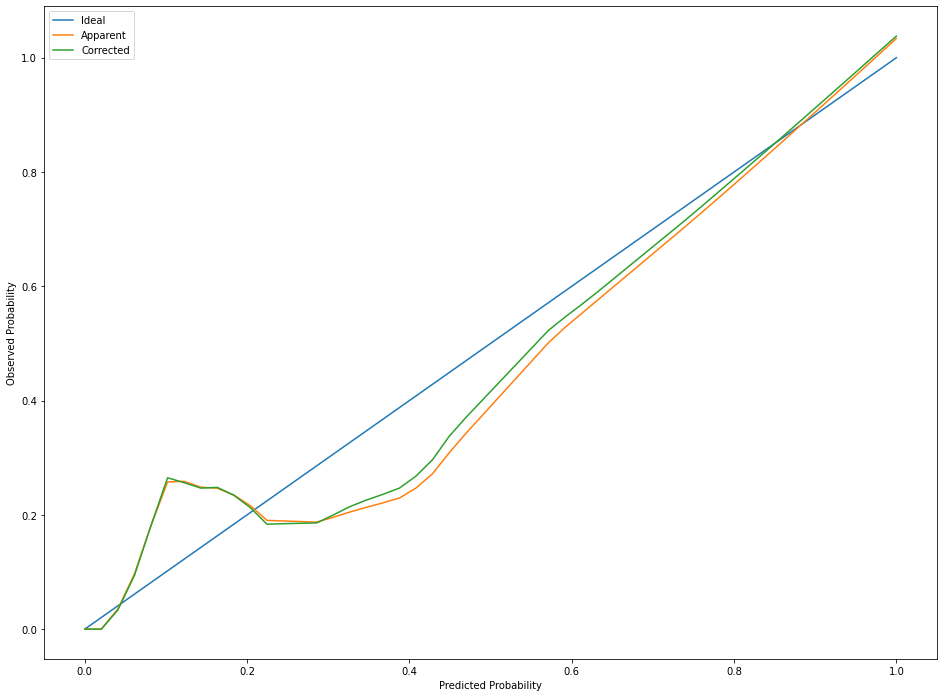

In [354]:
# "Ideal" 理想校准曲线 (y=x)
ideal_line = [0, 1]
plt.figure(
    figsize=(16, 12)
)
# 开始画图
# Ideal (理想曲线)
plt.plot(ideal_line, ideal_line, label='Ideal')
# Apparent (表观曲线)
plt.plot(predy, cal, label='Apparent')
# Corrected (修正曲线)
plt.plot(predy, corrected, label='Corrected')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Probability')
plt.legend()

# 传统方法

In [8]:
is_boot = True

In [9]:
y_true, y_prob = y, y_pred_prob

In [28]:
prob_true, prob_pred

(array([0.        , 0.        , 0.        , 0.5       , 0.        ,
        0.5       , 0.33333333, 1.        , 0.        , 0.        ,
        0.33333333, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.5       , 1.        , 0.        , 0.        ,
        1.        , 1.        , 0.66666667, 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        ]),
 array([1.86707822e-04, 2.70279889e-02, 5.02487970e-02, 7.40332178e-02,
        9.04376774e-02, 1.16200891e-01, 1.25660136e-01, 1.66568734e-01,
        1.93363122e-01, 2.02501641e-01, 2.23019447e-01, 2.87162350e-01,
        3.33455867e-01, 3.86384898e-01, 4.18482476e-01, 4.35094871e-01,
        4.50239775e-01, 5.77491930e-01, 5.85845670e-01, 6.24078936e-01,
        7.45296936e-01, 7.67041249e-01, 8.06029164e-01, 8.34832384e-01,
        8.56486434e-01, 9.26272793e-01, 9.49579154e-01, 9.75274737e-01,
        9.98321916e-01]))

In [29]:
prob_true.shape, prob_pred.shape

((29,), (29,))

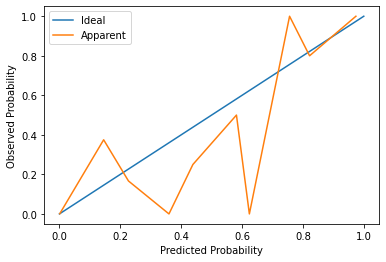

In [235]:
# 计算普通的校准曲线
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
# "Ideal" 理想校准曲线 (y=x)
ideal_line = [0, 1]
plt.figure()
# 开始画图
# Ideal (理想曲线)
plt.plot(ideal_line, ideal_line, label='Ideal')
# Apparent (表观曲线)
plt.plot(prob_pred, prob_true, label='Apparent')
# # 是否进行Boostrap有放回的采样
# if is_boot:
#     length = len(y_true)
#     boot_num = int(90 * length / 100)
#     np.random.seed(1024)  # 设置随机种子
#     bootstrap_curves = []
#     for i in range(100):
#         indices = np.random.choice(length, boot_num, replace=True)
#         y_resample_probs = y_prob[indices]
#         y_resample_true = y_true[indices]
#         # 计算重采样后的校准曲线
#         boot_prob_true, boot_prob_pred = calibration_curve(y_resample_true, y_resample_probs, n_bins=10, strategy='quantile')
#         # https://chatgpt.com/share/670f779b-c910-8010-92ab-7587668e7f48
#         # 使用插值来保证所有曲线的长度一致
#         # 对 true 和 pred 都进行插值，确保曲线长度一致
#         boot_prob_true_interp = np.interp(prob_pred, boot_prob_pred, boot_prob_true)
#         boot_prob_pred_interp = np.interp(prob_pred, boot_prob_pred, boot_prob_pred)
#         # 将插值后的校准曲线保存
#         bootstrap_curves.append((boot_prob_true_interp, boot_prob_pred_interp))
#     # 计算偏差校正后的平均校准曲线
#     mean_prob_true = np.mean([curve[0] for curve in bootstrap_curves], axis=0)
#     mean_prob_pred = np.mean([curve[1] for curve in bootstrap_curves], axis=0)
#     plt.plot(mean_prob_pred, mean_prob_true,label='Boostrap')
# 设置标签和图例
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Probability')
plt.legend()